In [394]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

In [395]:
raw_df = pd.read_csv('listings.csv')
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 3020 Airbnb listings


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6860,https://www.airbnb.com/rooms/6860,20190930152130,2019-09-30,Downtown Charmer - 17 Mins to NYC!,"Our 600sqft studio, located on the 2nd flr of ...","Bright, southern-facing open floor plan studio...","Our 600sqft studio, located on the 2nd flr of ...",none,Directly across the street from our home is th...,New York City is better when you stay with us....,"We are a safe, ""walkable"" neighborhood with ev...",Guests have a private entrance to the exclusiv...,We greet our guests upon arrival to ensure a s...,Absolutely no pets and no smoking anywhere wit...,NaN,NaN,https://a0.muscache.com/im/pictures/70026019/f...,NaN,16038,https://www.airbnb.com/users/show/16038,Festive,2009-05-06,"Jersey City, New Jersey, United States",My husband and I are a young professional coup...,within an hour,100%,NaN,f,https://a0.muscache.com/im/users/16038/profile...,https://a0.muscache.com/im/users/16038/profile...,NaN,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Jersey City, NJ, United States",NaN,Ward E (councilmember James Solomon),NaN,Jersey City,NJ,07302,New York,"Jersey City, NJ",US,United States,40.72613,-74.04811,t,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",NaN,$163.00,$900.00,"$2,600.00",$500.00,$95.00,2,$75.00,2,120,2,2,120,120,2.0,120.0,3 months ago,t,0,26,56,236,2019-09-30,41,14,2015-05-09,2019-08-16,92.0,9.0,9.0,10.0,10.0,10.0,9.0,f,NaN,"{""New Jersey State"","" Jersey City""}",t,f,moderate,f,f,3,3,0,0,0.77
1,26154,https://www.airbnb.com/rooms/26154,20190930152130,2019-10-01,"Beautiful apt., 10 min subway ride to Manhattan","Beautiful large apartment with living room, di...",""" We are ideally located in quiet Jersey City...","Beautiful large apartment with living room, di...",none,I love living here because you get the right m...,One of the best things about my apartment loca...,The best way to get around is on foot. You can...,The building has two washing machines and two ...,"I am available any time for guests via email, ...",NaN,NaN,NaN,https://a0.muscache.com/im/pictures/12106625/b...,NaN,102760,https://www.airbnb.com/users/show/102760,Javier,2010-04-03,"New York, New York, United States","Hello traveller,\r\nI am renting my one bedroo...",within a few hours,100

In [396]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1)

In [397]:
df.isna().sum()


id                                                 0
experiences_offered                                0
host_since                                         1
host_response_time                               151
host_response_rate                               151
host_acceptance_rate                            3020
host_is_superhost                                  1
host_listings_count                                1
host_total_listings_count                          1
host_has_profile_pic                               1
host_identity_verified                             1
street                                             0
neighbourhood                                   3019
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                    3020
city                                               1
state                                              1
zipcode                                            8
market                                        

In [398]:
df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

df.set_index('id', inplace=True) # The id will be used as the index, as this could be useful in future e.g. if a separate dataset containing reviews for each property is linked to this one

In [399]:
print(sum((df.host_listings_count == df.host_total_listings_count) == False))
df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]

1


,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
18476572,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Jersey City, NJ, United States",NaN,Ward E (councilmember James Solomon),Jersey City,NJ,07310,New York,"Jersey City, NJ",US,United States,40.72384,-74.0365,f,Apartment,Entire home/apt,6,2.0,2.0,3.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",$300.00,$250.00,$125.00,4,$10.00,5,1125,5,8,1125,1125,5.1,1125.0,today,t,19,49,79,354,2,0,2017-10-19,2017-10-22,100.0,10.0,10.0,10.0,9.0,10.0,10.0,f,t,f,strict_14_with_grace_period,f,f,1,1,0,0,0.08


In [400]:
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [401]:
lat_long = df[['latitude', 'longitude']]

In [402]:

df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

In [403]:
sum((df.minimum_nights == df.minimum_minimum_nights) == False)

377

In [404]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

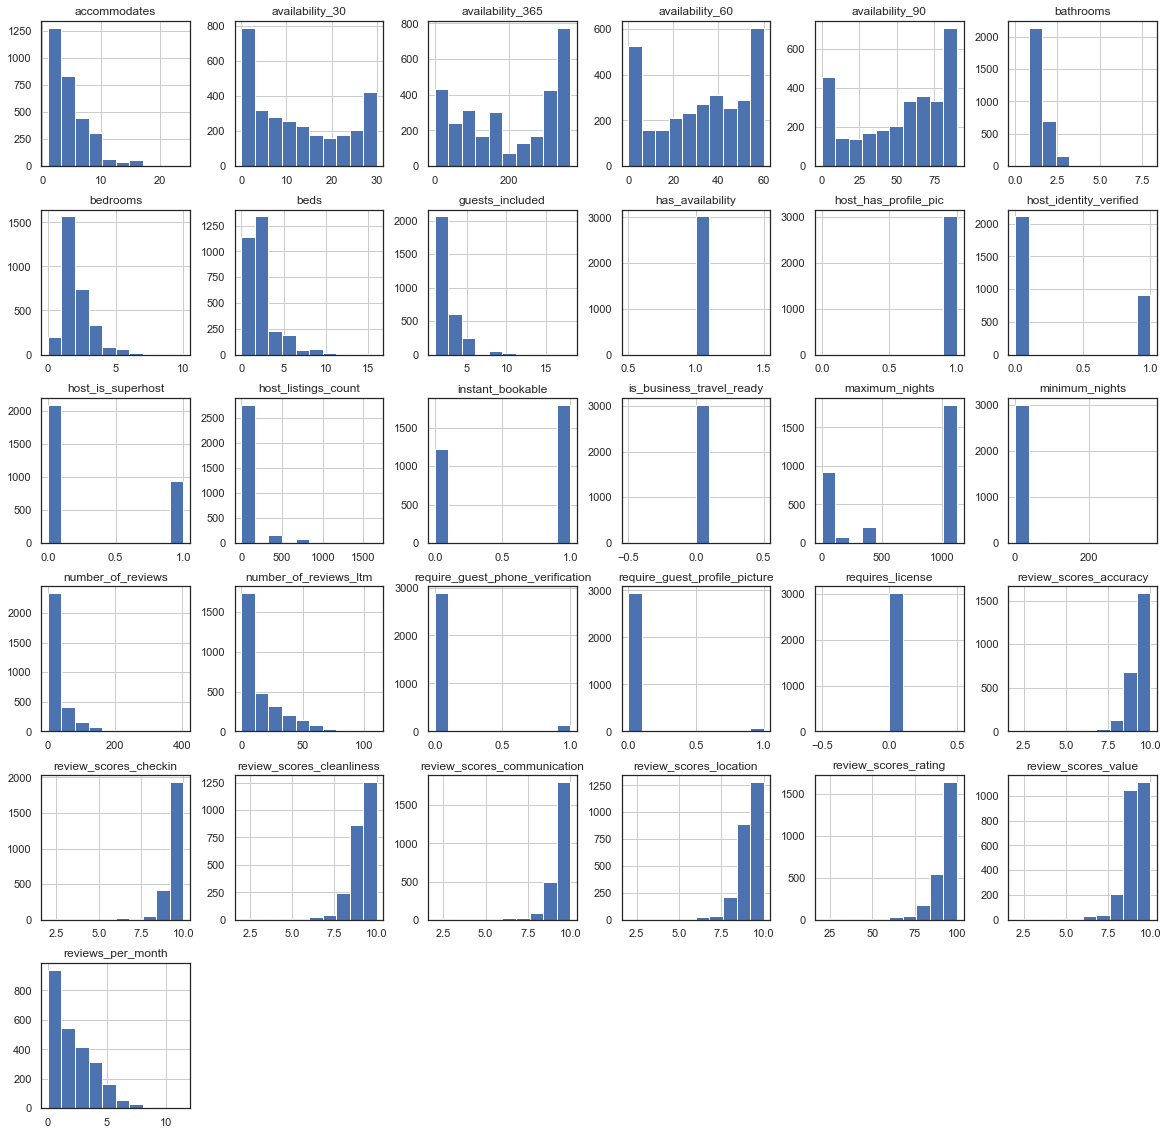

In [405]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20));

In [406]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)


In [407]:
df.experiences_offered.value_counts()

none    3020
Name: experiences_offered, dtype: int64

In [408]:
df.drop('experiences_offered', axis=1, inplace=True)

In [409]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime(2019, 4, 9) - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1126.0
Median days as host: 982.0


In [410]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# Number of rows without a value for host_response_time which have also not yet had a review
len(df[df.loc[ :,['host_response_time ', 'first_review'] ].isnull().sum(axis=1) == 2])

Null values: 151
Proportion: 5.0%


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


547

In [411]:
df.host_response_time.fillna("unknown", inplace=True)
df.host_response_time.value_counts(normalize=True)

within an hour        0.756291
within a few hours    0.113907
within a day          0.073510
unknown               0.050000
a few days or more    0.006291
Name: host_response_time, dtype: float64

In [412]:
df.host_response_time.value_counts(normalize=True)

within an hour        0.756291
within a few hours    0.113907
within a day          0.073510
unknown               0.050000
a few days or more    0.006291
Name: host_response_time, dtype: float64

In [413]:
print("Null values:", df.host_response_rate.isna().sum())
print(f"Proportion: {round((df.host_response_rate.isna().sum()/len(df))*100, 1)}%")

Null values: 151
Proportion: 5.0%


In [414]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")


Mean host response rate: 96.0
Median host response rate: 100.0
Proportion of 100% host response rates: 58.0%


In [415]:
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       1664
90-99%      793
50-89%      383
unknown     151
0-49%        29
Name: host_response_rate, dtype: int64

In [416]:
# Number of rows without a value for multiple host-related columns
len(df[df.loc[ :,['host_since ', 'host_is_superhost', 'host_listings_count', 'host_has_profile_pic', 'host_identity_verified'] ].isnull().sum(axis=1) == 5])

1

In [417]:
df.dropna(subset=['host_since'], inplace=True)

In [418]:
df.property_type.value_counts()

Apartment             2004
House                  497
Condominium            162
Townhouse              136
Serviced apartment     111
Loft                    32
Guest suite             27
Other                   16
Boutique hotel          15
Bungalow                 4
Guesthouse               3
Bed and breakfast        3
Aparthotel               2
Tiny house               2
Cabin                    1
Castle                   1
Dome house               1
Cottage                  1
Hostel                   1
Name: property_type, dtype: int64

In [419]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House'  
    }, inplace=True)

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'

In [420]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

In [421]:
df.bed_type.value_counts()

Real Bed         2995
Futon              12
Airbed              6
Pull-out Sofa       4
Couch               2
Name: bed_type, dtype: int64

In [422]:
df.drop('bed_type', axis=1, inplace=True)

In [423]:
df.amenities[:1].values

array(['{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Free street parking",Heating,"Smoke detector","Carbon monoxide detector","First aid kit","Safety card","Fire extinguisher",Essentials,Shampoo,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","translation missing: en.hosting_amenity_49","translation missing: en.hosting_amenity_50","Self check-in",Keypad,"Private entrance","Hot water","Bed linens","Extra pillows and blankets",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Cooking basics",Stove,"Luggage dropoff allowed","Long term stays allowed"}'],
      dtype=object)

In [424]:
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beachfront',
 'Bed linens',
 'Breakfast',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Cooking basics',
 'Crib',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'Essentials',
 'Ethernet connection',
 'Extra pillows and blankets',
 'Extra space around bed',
 'Family/kid friendly',
 'Fire extinguisher',
 'Fireplace guards',
 'Firm mattress',
 'First aid kit',
 'Fixed grab bars for shower',
 'Fixed grab bars for toilet',
 'Flat path to guest entrance',
 'Free parking on 

In [425]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [426]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,41:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'high_end_electronics', 'nature_and_views', 'breakfast', 'host_greeting', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


In [427]:
df.columns[40:]

Index(['air_conditioning', 'bbq', 'balcony', 'bed_linen', 'tv',
       'coffee_machine', 'cooking_basics', 'white_goods', 'elevator', 'gym',
       'child_friendly', 'parking', 'outdoor_space', 'hot_tub_sauna_or_pool',
       'internet', 'long_term_stays', 'pets_allowed', 'private_entrance',
       'self_check_in'],
      dtype='object')

In [428]:
df.price = df.price.str[1:-3]
df.price = df.price.str.replace(",", "")
df.price = df.price.astype('int64')

In [429]:
df.security_deposit.isna().sum()

532

In [430]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')

In [431]:
df.cleaning_fee.isna().sum()



221

In [432]:
df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

In [433]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

In [434]:
print("Number of categories:", df.calendar_updated.nunique())
print("\nTop five categories:")
df.calendar_updated.value_counts()[:5]

Number of categories: 49

Top five categories:


today          799
2 weeks ago    363
3 weeks ago    358
a week ago     252
yesterday      193
Name: calendar_updated, dtype: int64

In [435]:
df.drop('calendar_updated', axis=1, inplace=True)

In [436]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [437]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating .isna().sum()/len(df),1)}%")

Null values in 'first_review': 18.1%
Null values in 'review_scores_rating': 18.7%


In [438]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime(2019, 4, 9) - df.first_review).astype('timedelta64[D]')

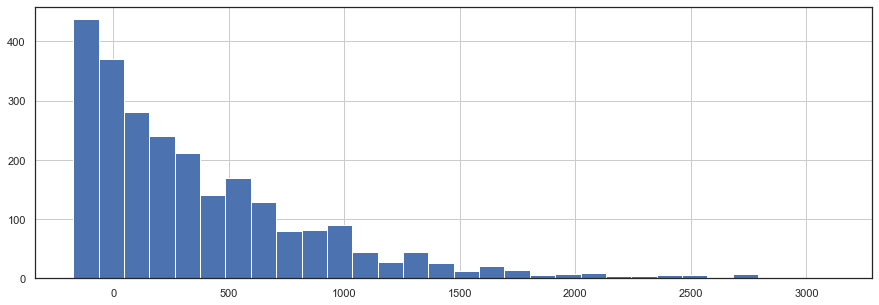

In [439]:
df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [440]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [441]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

In [442]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime(2019, 4, 9) - df.last_review).astype('timedelta64[D]')

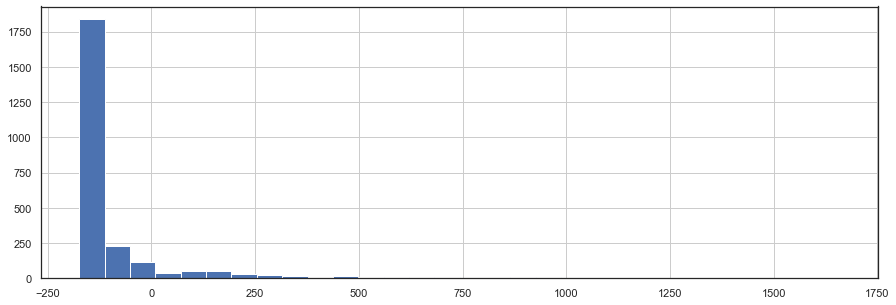

In [443]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30);


In [444]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [445]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)

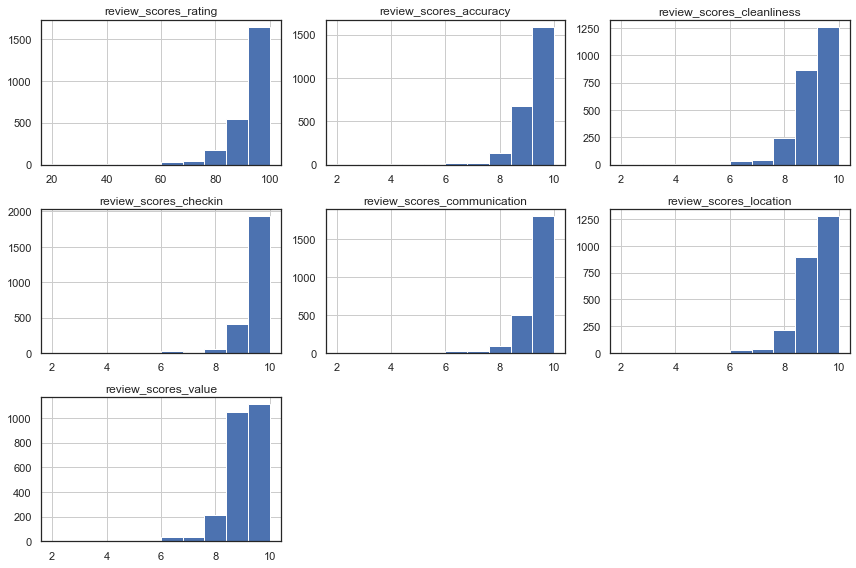

In [446]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()


In [447]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [448]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [449]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

In [450]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    1796
moderate                        691
flexible                        522
super_strict_60                   4
strict                            4
super_strict_30                   2
Name: cancellation_policy, dtype: int64

In [451]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [452]:
df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

In [453]:
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 06 May 2009, and the most recent joined on 29 September 2019.


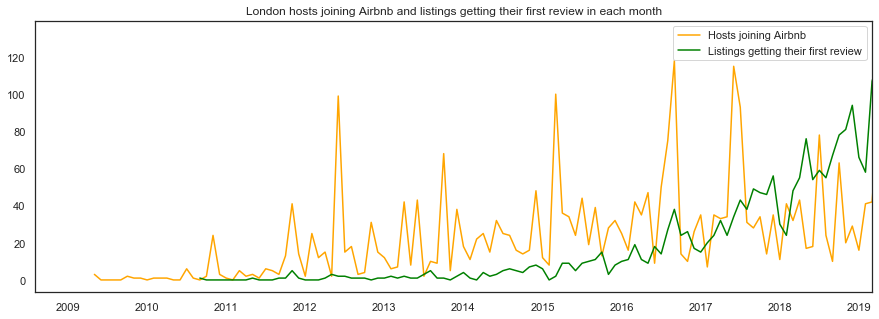

In [454]:
plt.figure(figsize=(15,5))
df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('London hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [455]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [456]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

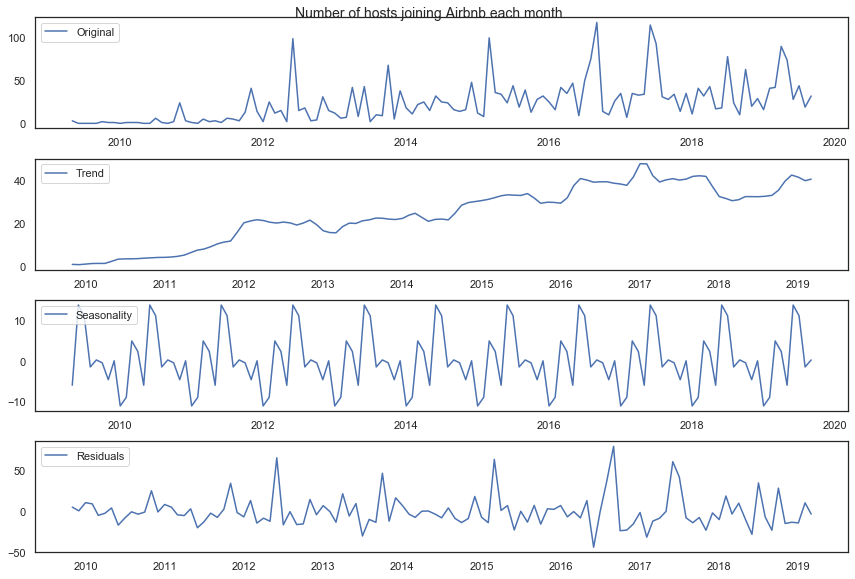

In [457]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

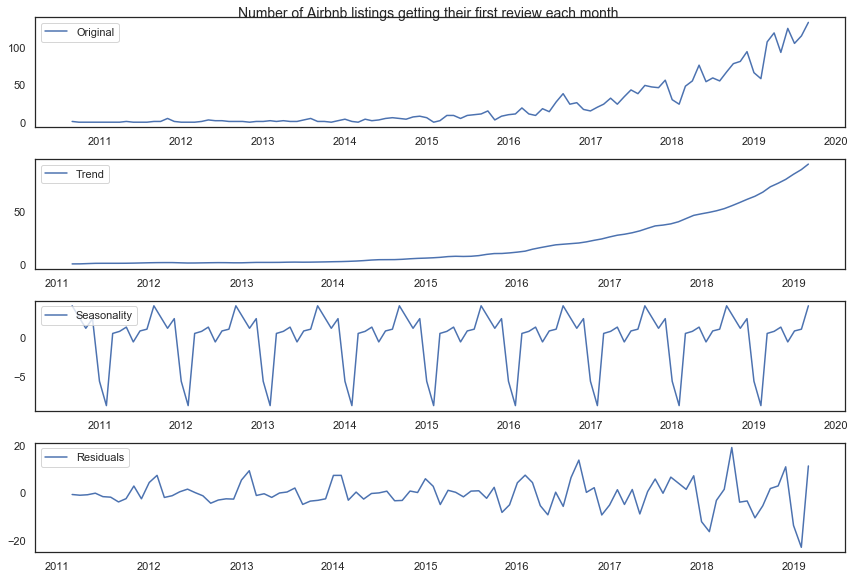

In [458]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


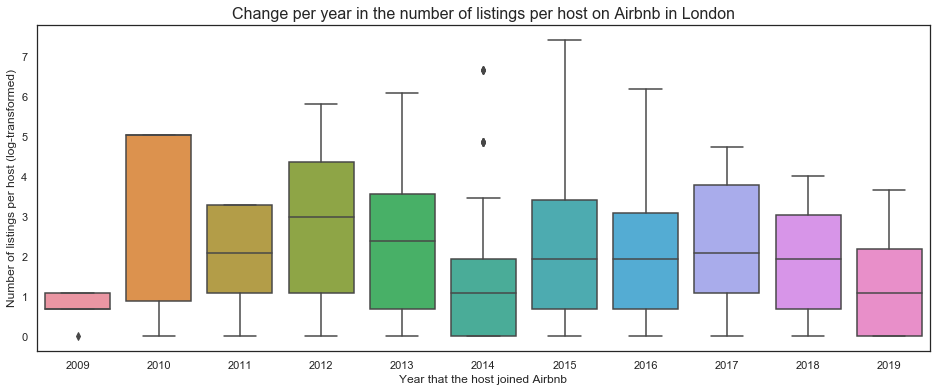

In [459]:
plt.figure(figsize=(16,6))
sns.boxplot(df.host_since.dt.year, np.log(df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in London', fontsize=16)
plt.show()

In [460]:
print("Average number of listings per host per year on Airbnb in London:")
print(round(df.set_index('host_since').host_listings_count.resample('YS').mean(),2))

Average number of listings per host per year on Airbnb in London:
host_since
2009-01-01      2.29
2010-01-01     93.05
2011-01-01     11.91
2012-01-01     58.14
2013-01-01     93.50
2014-01-01     25.45
2015-01-01    180.03
2016-01-01    103.49
2017-01-01     29.69
2018-01-01     14.04
2019-01-01      6.79
Freq: AS-JAN, Name: host_listings_count, dtype: float64


In [461]:
# List of the largest host_listings_count and the year the host joined Airbnb
df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
id,,
23248742,2017-12-19,114.0
15447154,2014-10-14,131.0
1767237,2010-11-19,156.0
32044588,2016-08-07,314.0
16944874,2012-11-13,337.0
22792305,2013-10-14,440.0
21859295,2016-09-16,492.0
15158307,2015-03-30,727.0
33485044,2014-12-14,780.0


/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


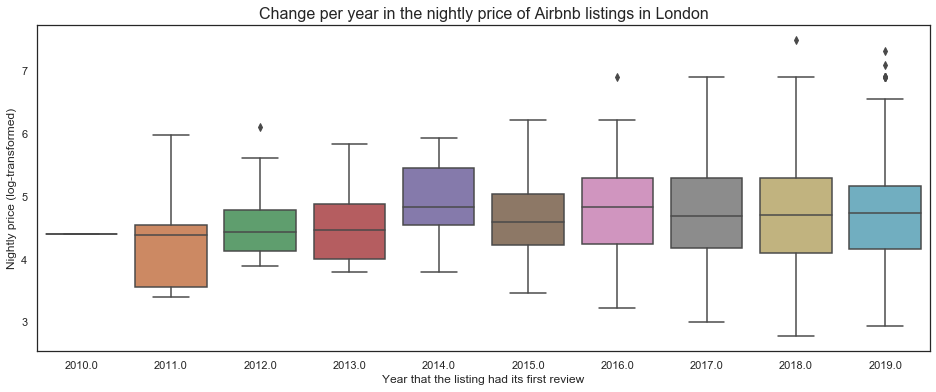

In [462]:
plt.figure(figsize=(16,6))
sns.boxplot(df.first_review.dt.year, np.log(df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in London', fontsize=16)
plt.show()

In [463]:
print("Mean nightly price of listings in each year on Airbnb in London:")
print(round(df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in London:
first_review
2010-01-01     82.00
2011-01-01    100.56
2012-01-01    129.83
2013-01-01    109.25
2014-01-01    160.51
2015-01-01    134.08
2016-01-01    155.50
2017-01-01    151.27
2018-01-01    151.34
2019-01-01    146.56
Name: price, dtype: float64


In [464]:
# Dropping host_since and first_review as they are no longer needed
df.drop(['host_since', 'first_review'], axis=1, inplace=True)

In [465]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,instant_bookable,host_days_active,air_conditioning,bbq,balcony,bed_linen,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,self_check_in
count,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000,3019.000000
mean,0.308049,62.932428,0.301093,4.599868,1.361709,1.619079,2.388870,163.038755,138.880093,73.722425,2.364028,12.950315,4.242133,710.427956,52.306393,27.459424,0.594899,1125.962239,0.941703,0.122557,0.137794,0.522027,0.798940,0.507453,0.466711,0.668102,0.292812,0.237827,0.367009,0.588937,0.124876,0.214641,0.988407,0.397483,0.179198,0.427956,0.465055
std,0.461763,165.345843,0.458809,3.156543,0.613930,1.111412,1.799369,270.866273,236.945047,57.088352,2.045128,18.643481,13.203158,509.950356,30.296008,41.300407,0.490993,846.309384,0.234344,0.327982,0.344741,0.499597,0.400859,0.500027,0.498973,0.470973,0.455128,0.425823,0.482069,0.492108,0.330633,0.410641,0.107064,0.489458,0.383582,0.494864,0.498860
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2.000000,1.000000,1.000000,1.000000,65.000000,0.000000,30.000000,1.000000,0.000000,1.000000,45.000000,28.000000,1.000000,0.000000,420.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,6.000000,0.000000,4.000000,1.000000,1.000000,2.000000,120.000000,0.000000,75.000000,1.000000,10.000000,2.000000,1125.000000,59.000000,11.000000,1.000000,982.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,24.000000,1.000000,6.000000,2.000000,2.000000,3.000000,200.000000,250.000000,100.000000,4.000000,20.000000,3.000000,1125.000000,79.000000,37.000000,1.000000,1740.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1664.000000,1.000000,24.000000,8.000000,10.000000,16.000000,9999.000000,5000.000000,500.000000,18.000000,300.000000,365.000000,1125.000000,90.000000,403.000000,1.000000,3625.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [466]:
print(f"Nightly advertised prices range from £{min(df.price)} to £{max(df.price)}.")

Nightly advertised prices range from £0 to £9999.


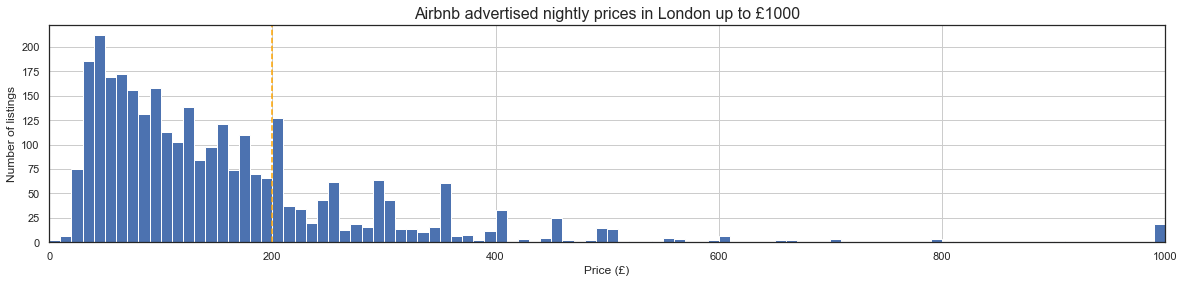

In [467]:
# Distribution of prices from £0 to £1000
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

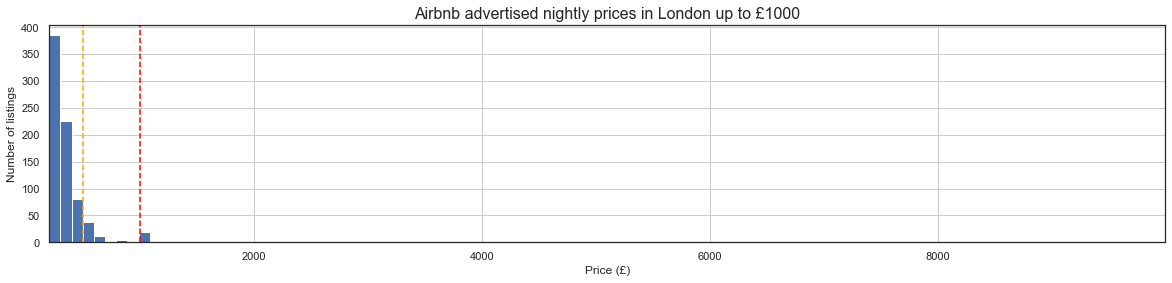

In [468]:
# Distribution of prices from £200 upwards
plt.figure(figsize=(20,4))
df.price.hist(bins=100, range=(200, max(df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to £1000", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [469]:
# Replacing values under £10 with £10
df.loc[df.price <= 10, 'price'] = 10

# Replacing values over £1000 with £1000
df.loc[df.price >= 1000, 'price'] = 1000

In [470]:
print("Median number of listings per host:", int(df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(df.host_listings_count.mean())))
print(f"{int(round(100*len(df[df.host_listings_count == 1])/len(df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 6
Mean number of listings per host: 63
20% of listings are from hosts with one listing.


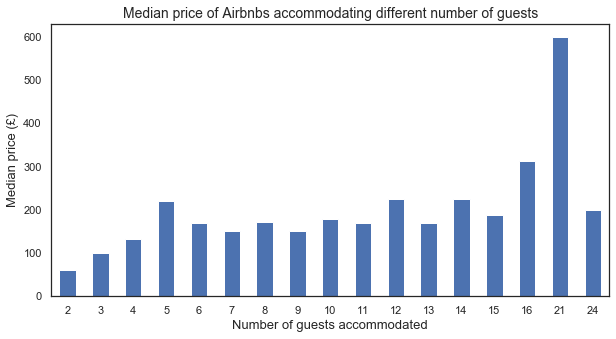

In [471]:
plt.figure(figsize=(10,5))
df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

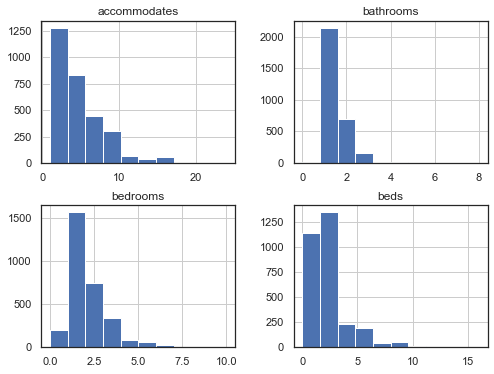

In [472]:
df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

In [473]:
# Renaming the neighbourhood column
df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Ward E (councilmember James Solomon),None,"(POLYGON ((-74.051492 40.711752, -74.046679999..."
1,Ward B (councilmember Mira Prinz-Arey),None,"(POLYGON ((-74.08074000000001 40.71407, -74.08..."
2,Ward F (councilmember Jermaine D. Robinson),None,"(POLYGON ((-74.067217 40.724821, -74.064192000..."
3,Ward C (councilmember Richard Boggiano),None,"(POLYGON ((-74.054872 40.74334, -74.054545 40...."
4,Ward A (councilmember Denise Ridley),None,"(POLYGON ((-74.08556 40.709946, -74.0856639999..."


In [474]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)


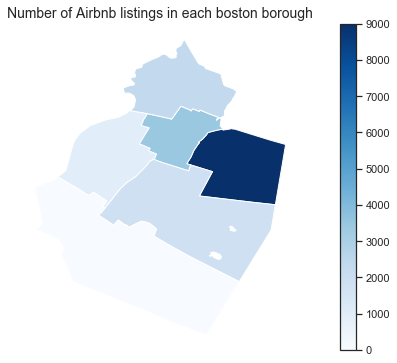

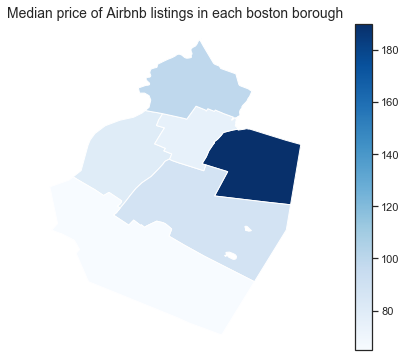

In [475]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each boston borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each boston borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

In [476]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

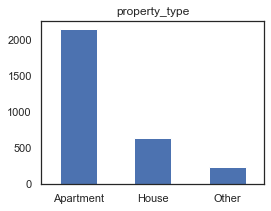

Apartment    0.711163
House        0.211991
Other        0.076847
Name: property_type, dtype: float64


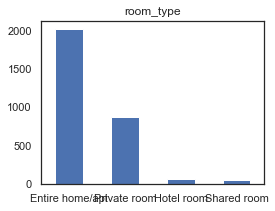

Entire home/apt    0.669096
Private room       0.290825
Hotel room         0.022193
Shared room        0.017887
Name: room_type, dtype: float64


In [477]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(df[col].value_counts(normalize=True))

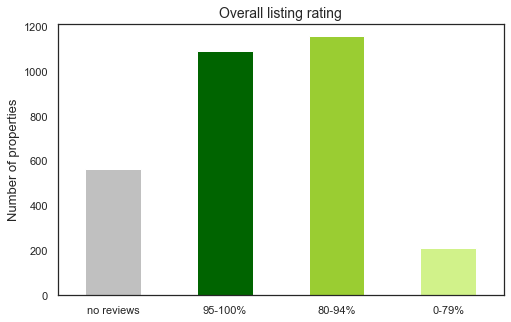

In [478]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

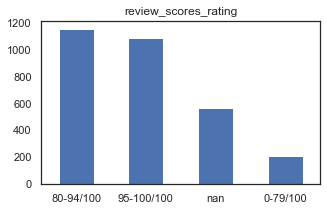

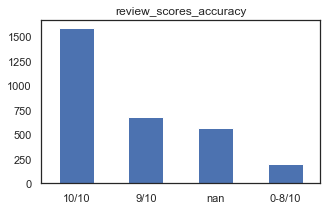

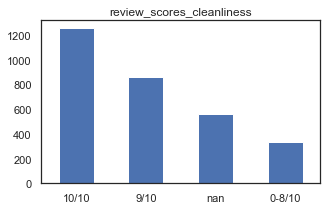

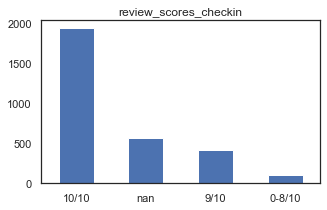

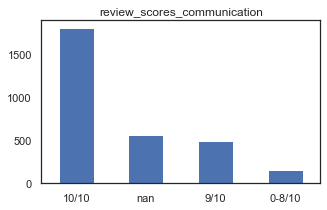

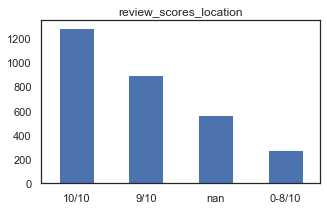

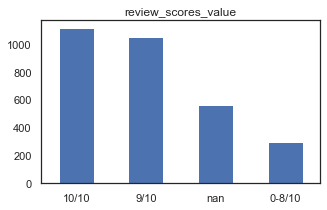

In [479]:
for col in list(df.columns[df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

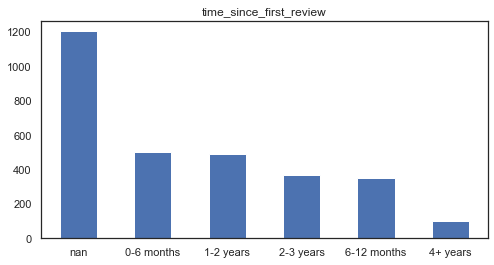

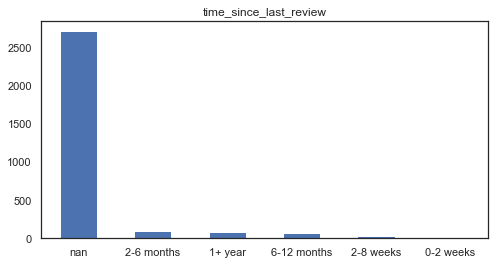

In [480]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

In [481]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()


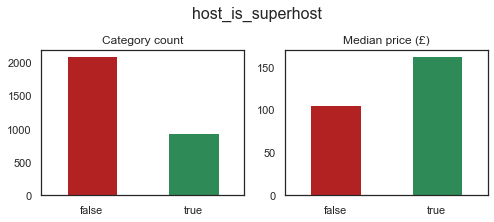

0.0    0.691951
1.0    0.308049
Name: host_is_superhost, dtype: float64


In [482]:
binary_count_and_price_plot('host_is_superhost')
print(df.host_is_superhost.value_counts(normalize=True))

In [483]:
df.host_identity_verified.value_counts(normalize=True)

0.0    0.698907
1.0    0.301093
Name: host_identity_verified, dtype: float64

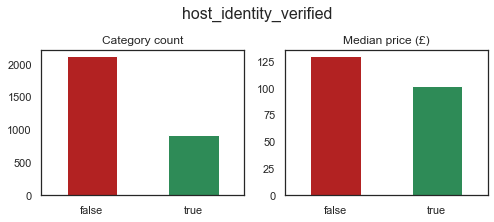

In [484]:
binary_count_and_price_plot('host_identity_verified')

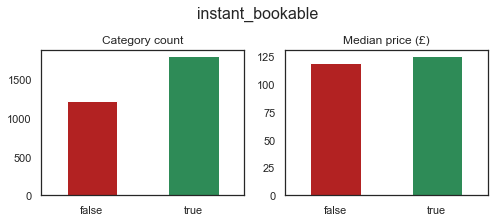

1    0.594899
0    0.405101
Name: instant_bookable, dtype: float64


In [485]:
binary_count_and_price_plot('instant_bookable')
print(df.instant_bookable.value_counts(normalize=True))

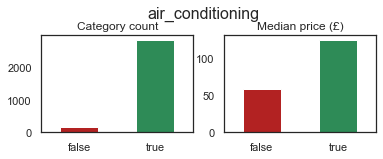

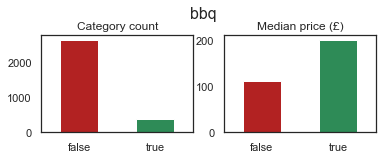

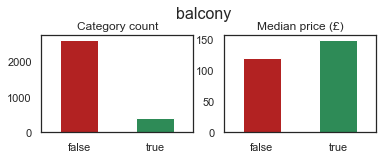

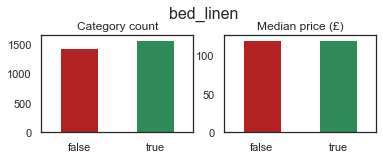

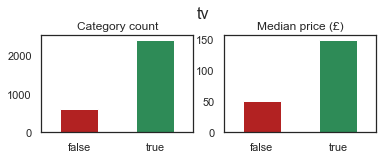

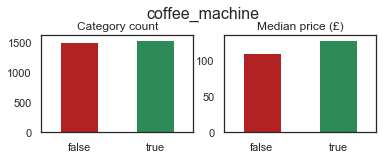

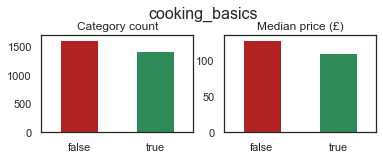

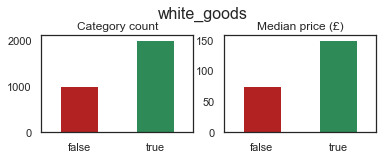

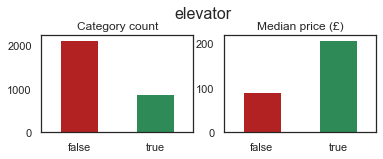

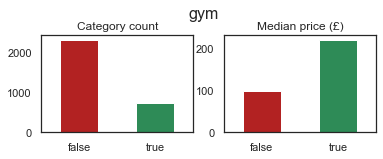

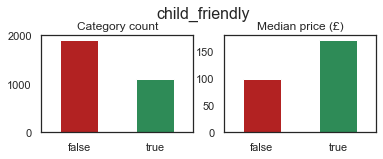

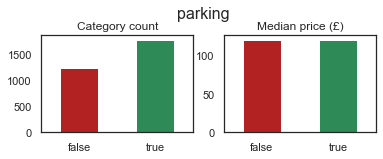

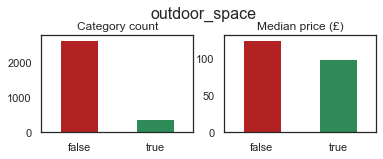

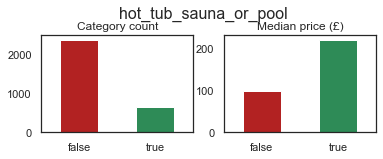

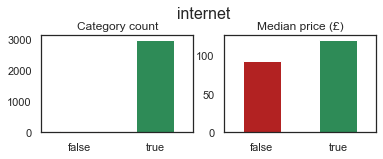

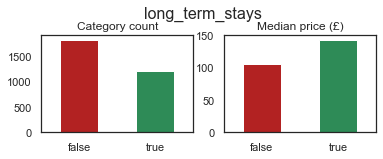

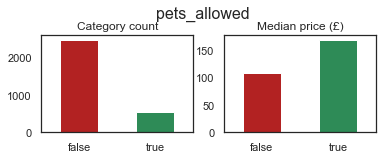

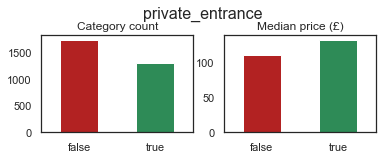

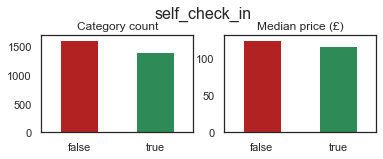

In [486]:
for col in df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

In [487]:
transformed_df = pd.get_dummies(df)

In [488]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());


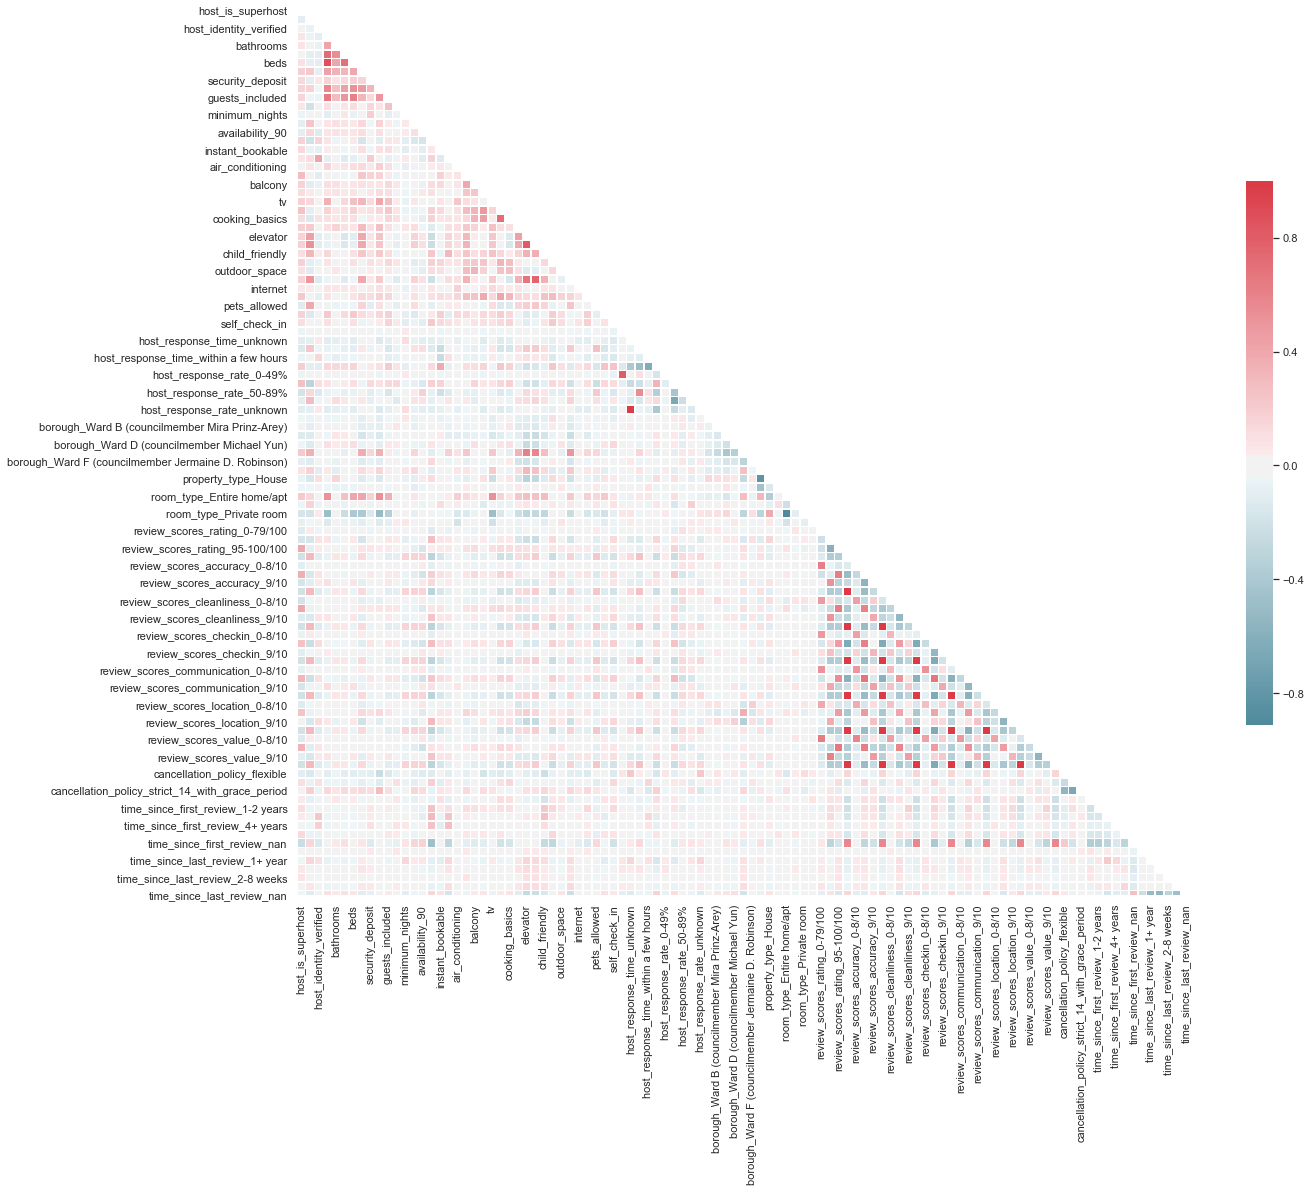

In [489]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

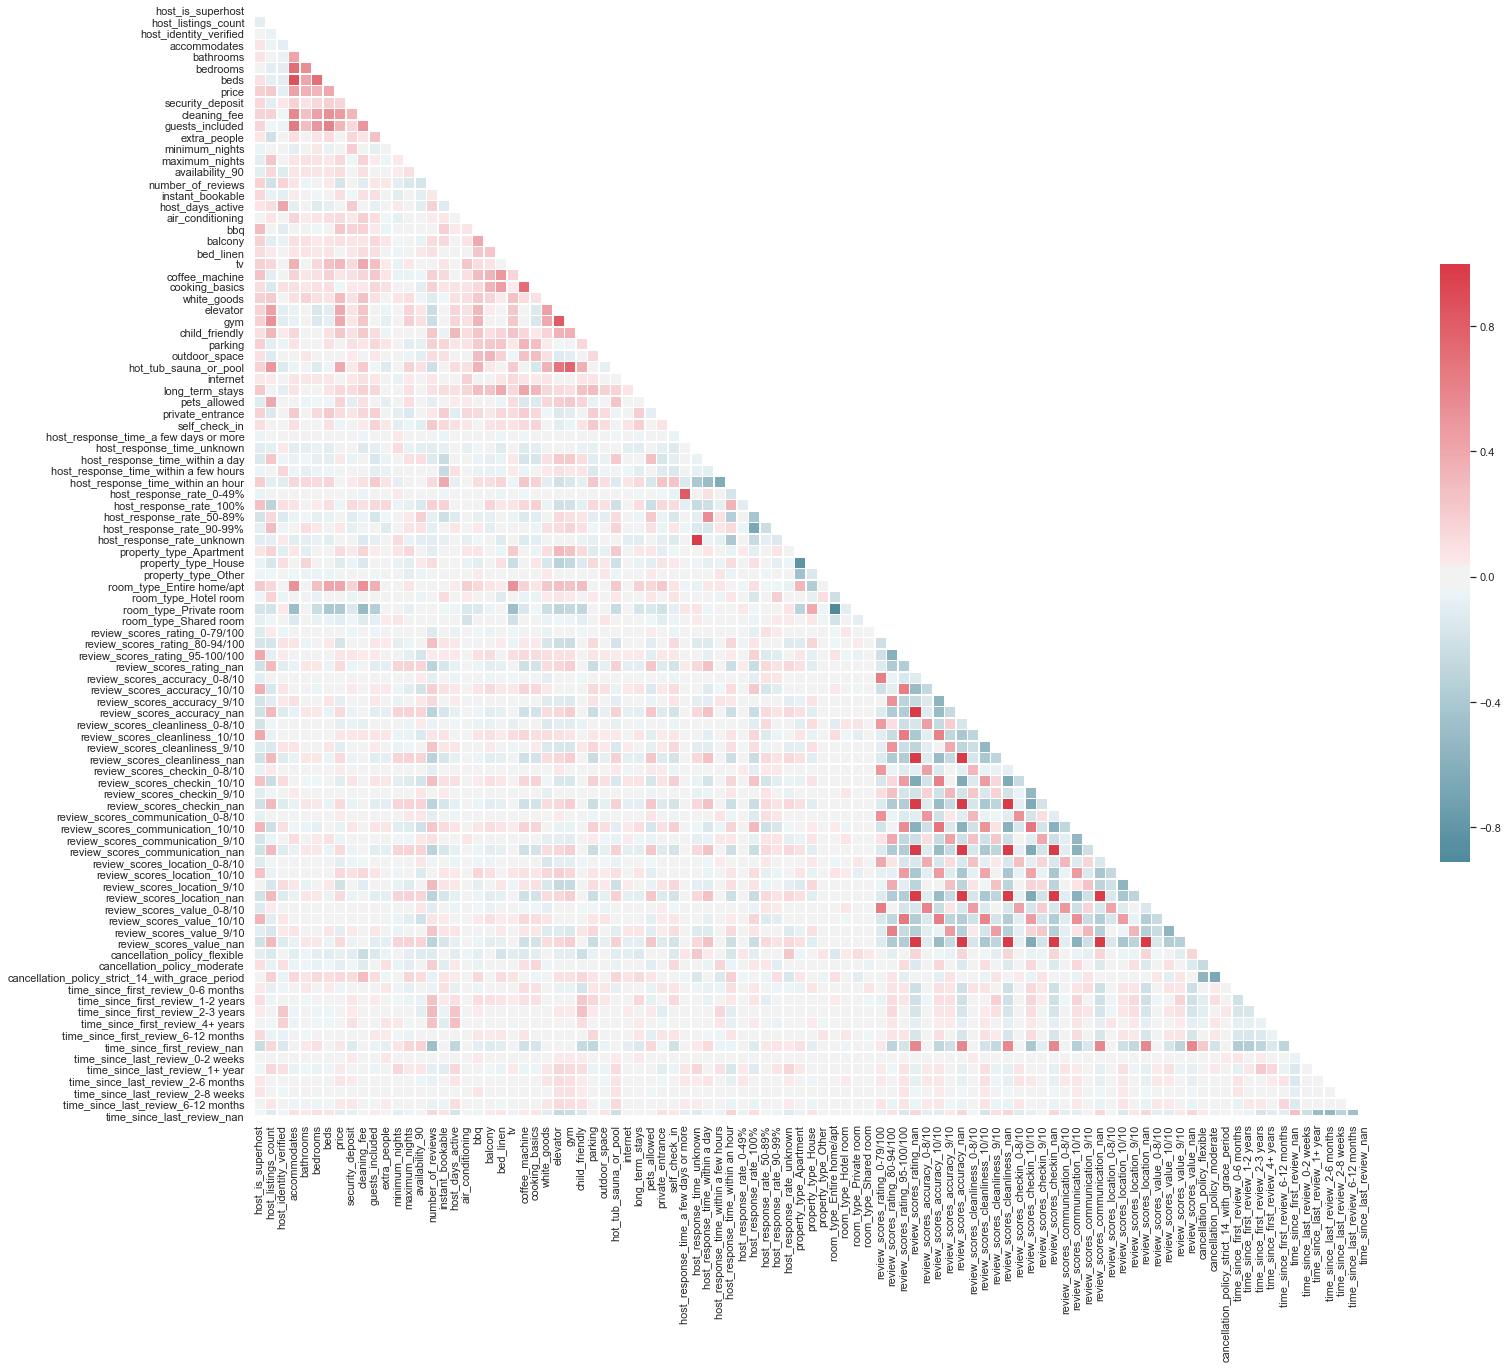

In [490]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [491]:
# Dropping collinear features
to_drop = ['beds',
           'bedrooms',
           'guests_included', 
           'host_response_rate_unknown',
           'host_response_rate_0-49%',
           'property_type_Apartment',
           'room_type_Private room']
to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

transformed_df.drop(to_drop, axis=1, inplace=True)

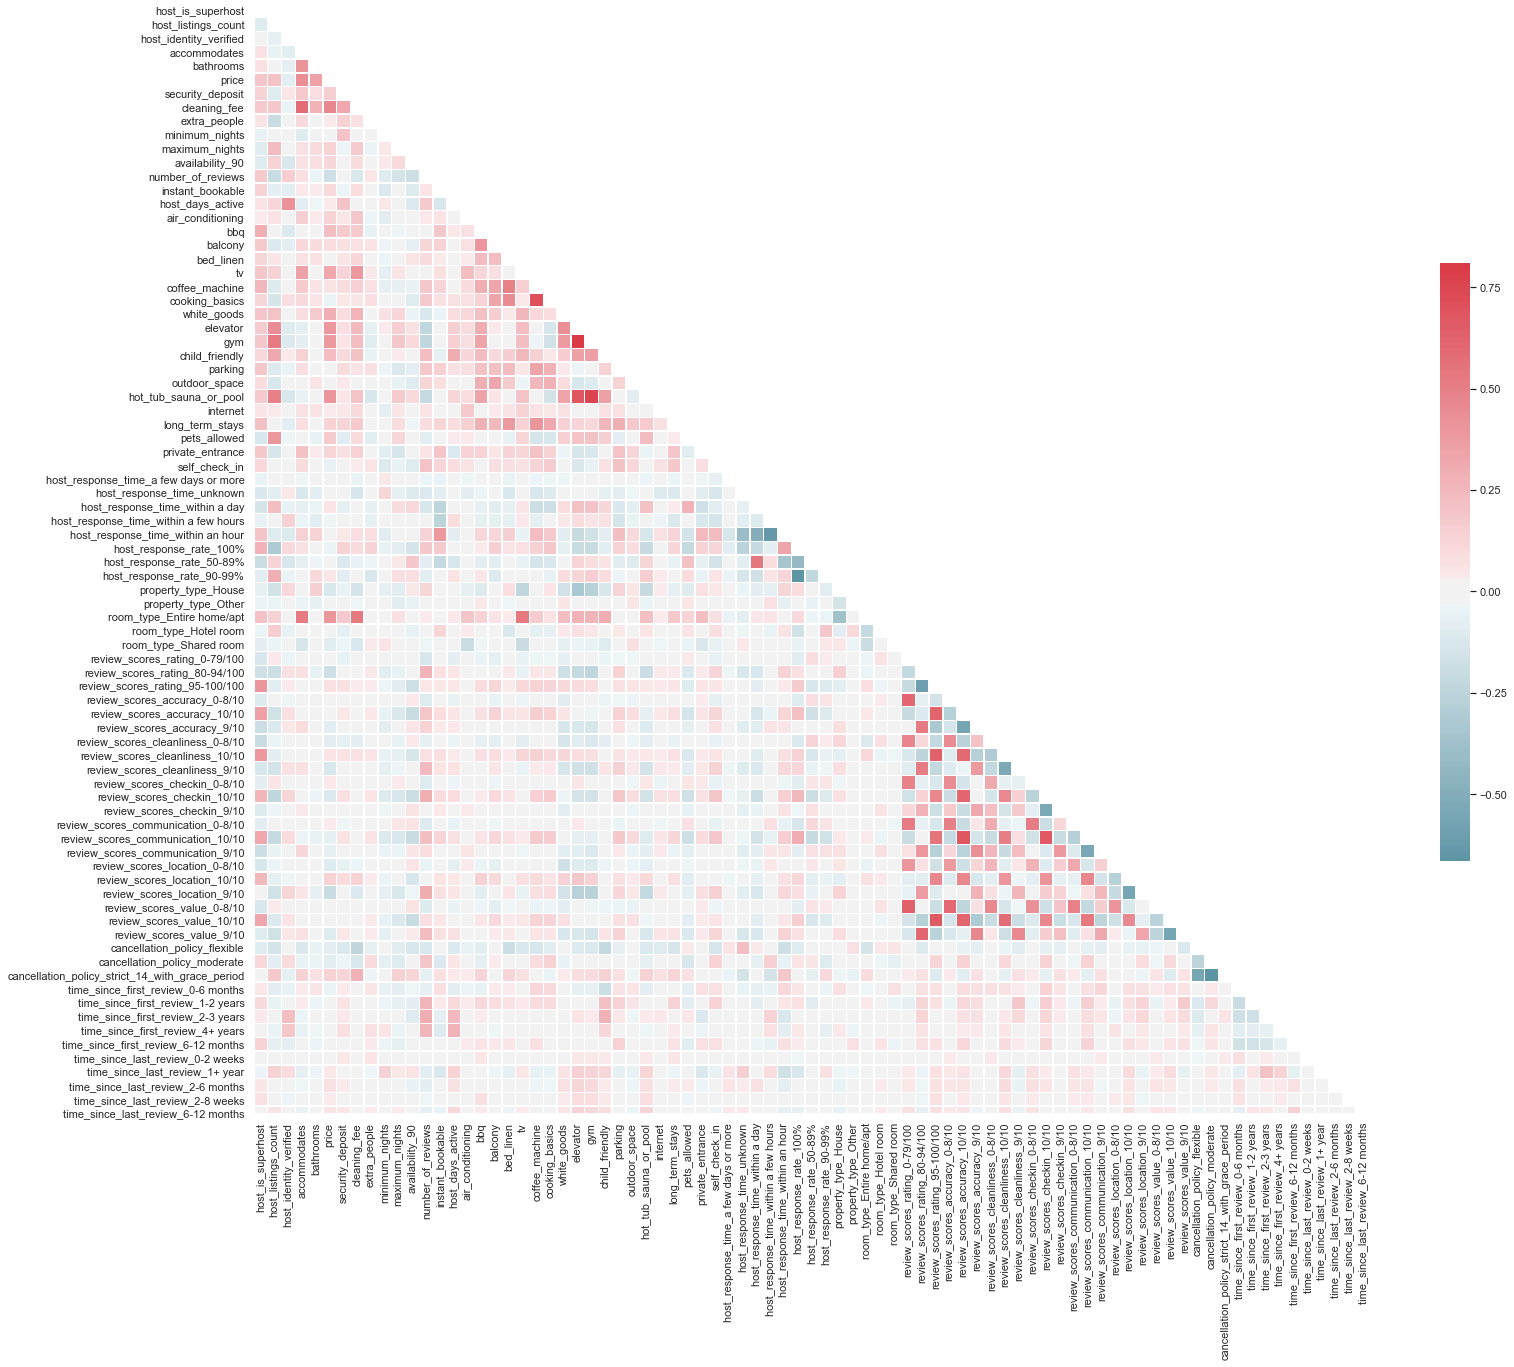

In [492]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('borough')]), axis=1), figsize=(25,22))

In [493]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

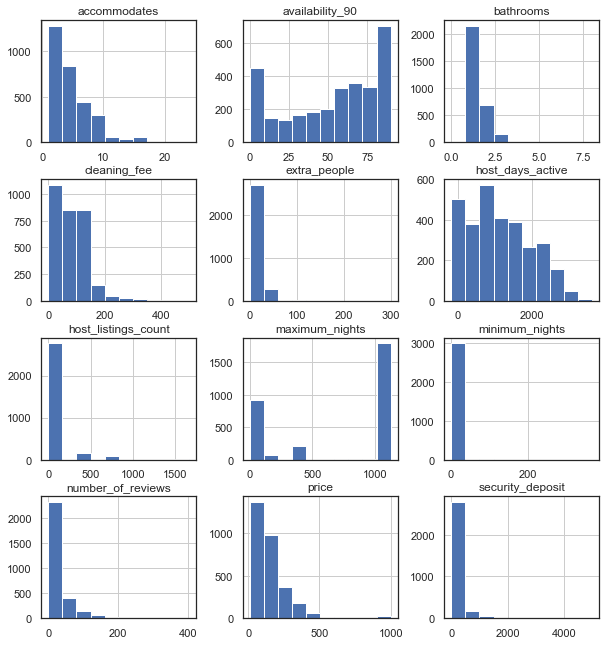

In [494]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [495]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    transformed_df[col] = transformed_df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    transformed_df[col] = np.log(transformed_df[col])

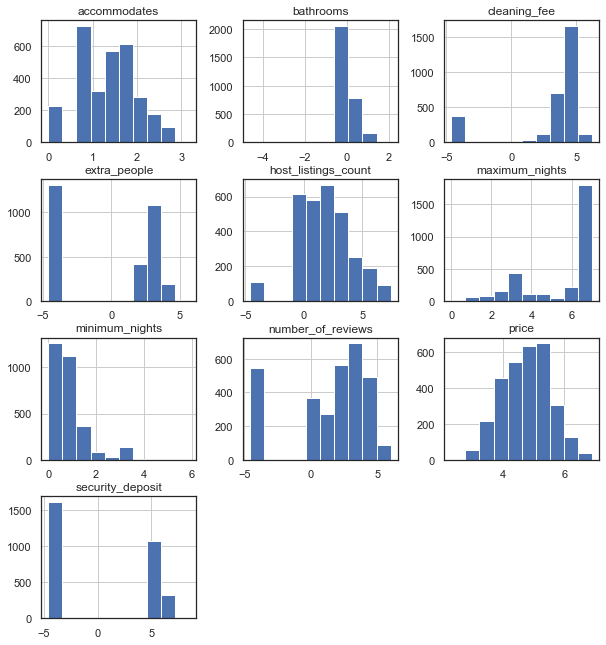

In [496]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [497]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [498]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [499]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

/usr/local/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:30:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time taken to run: 0.0 minutes

Training MSE: 0.0882
Validation MSE: 0.119

Training r2: 0.8546
Validation r2: 0.7907


In [500]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg

,weight
time_since_last_review_6-12 months,0.000000
review_scores_value_10/10,0.000000
internet,0.000000
review_scores_communication_10/10,0.000000
review_scores_communication_0-8/10,0.000000
host_response_time_within a few hours,0.000000
review_scores_checkin_9/10,0.000000
review_scores_checkin_10/10,0.000000
review_scores_value_9/10,0.000000
review_scores_checkin_0-8/10,0.000000


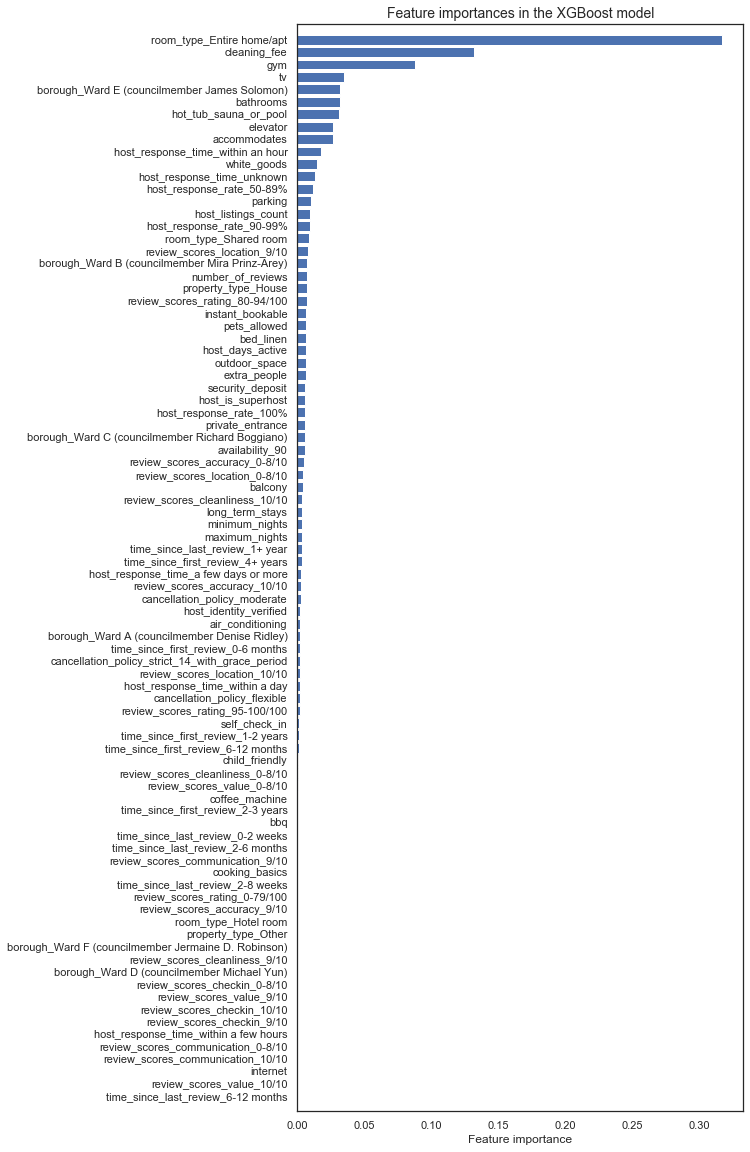

In [501]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

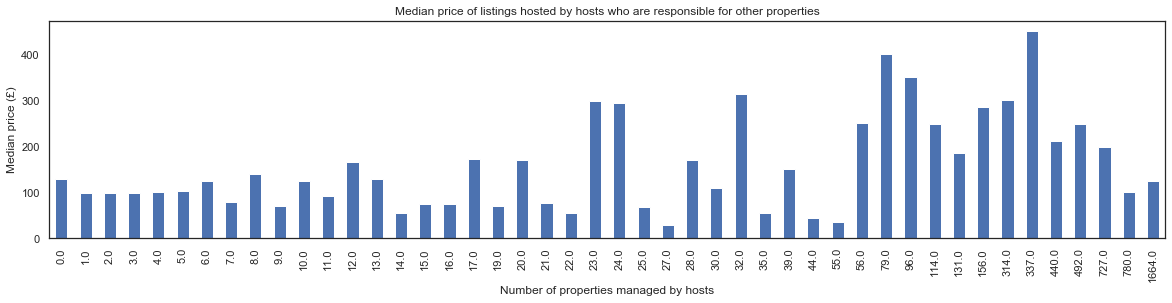

In [502]:
# Median price for different host listing counts
plt.figure()
df.groupby('host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price (£)');

In [503]:
#MODEL 4

In [504]:
all_review = list(X_train.columns[X_train.columns.str.startswith("review_scores")])
review_to_keep = list(X_train.columns[X_train.columns.str.startswith("review_scores_rating")])
review_to_drop = [x for x in all_review if x not in review_to_keep]

X_train_short = X_train.drop(review_to_drop, axis=1)
X_test_short = X_test.drop(review_to_drop, axis=1)

In [505]:
# Building the model
nn7 = models.Sequential()
nn7.add(layers.Dense(128, input_shape=(X_train_short.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn7.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn7.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn7.summary())

# Visualising the neural network
SVG(model_to_dot(nn7, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

AttributeError: module 'tensorflow' has no attribute 'get_default_graph'